In [1]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import time
import re
import string
import json
import pickle
from collections import defaultdict

%matplotlib inline

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from bs4 import BeautifulSoup
# The "requests" library makes working with HTTP requests easier
# than the built-in urllib libraries.
import requests
from urllib2 import urlopen

#Preliminary Data Cleaning

In [66]:
data=pd.read_csv("../data/anime_info.csv",sep='\t', index_col=0)

IOError: File ../data/anime_info.csv does not exist

In [3]:
data.shape

(7281, 11)

In [4]:
data[1:100]

,altname,atype,categories,date,date_pub,description,name,rank,rating,related,studio
+A-Channel,NaN,\nDVD Special (11 eps x 2 min),"[Comedy, Slice of Life, Based on a Manga]",NaN,2011,There are many untold stories in the lives of ...,+A-Channel,"\n Rank #2,398","3.334 of 5 from 1,192 votes","[A-Channel, A-Channel + smile]",Studio Gokumi
.hack//G.U. Returner,NaN,\nOVA (1 ep),"[MMORPG, RPG, Virtual Reality]",NaN,2007,"""There is something I wish to entrust to you; ...",.hack//G.U. Returner,"\n Rank #2,504","3.291 of 5 from 2,021 votes","[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN
.hack//G.U. Trilogy,NaN,\nMovie (1 ep x 93 min),"[CG Animation, MMORPG, RPG, Virtual Reality]",NaN,2008,The World is an ordinary online game – or at l...,.hack//G.U. Trilogy,"\n Rank #1,576","3.671 of 5 from 2,814 votes","[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN
.hack//G.U. Trilogy Parody,NaN,\nDVD Special (1 ep x 6 min),"[Comedy, MMORPG, RPG, Virtual Reality]",NaN,2008,NaN,.hack//G.U. Trilogy Parody,"\n Rank #3,993",2.691 of 5 from 714 votes,"[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN
.hack//GIFT,NaN,\nOVA (1 ep),"[Chibi, MMORPG, RPG, Virtual Reality]",NaN,2003,"As thanks for playing in The World, its makers...",.hack//GIFT,"\n Rank #4,108","2.646 of 5 from 2,721 votes","[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",BEE TRAIN
.hack//LIMINALITY,NaN,\nOVA (4 eps),NaN,NaN,2002,"While characters within the MMORPG entitled ""T...",.hack//LIMINALITY,"\n Rank #3,073","3.064 of 5 from 4,253 votes","[.hack//SIGN, .hack//Legend Of The Twilight, ....",BEE TRAIN
.hack//Legend Of The Twilight,NaN,\nTV (12 eps),"[Sci Fi, MMORPG, RPG, Virtual Reality]",NaN,2003,Shuugo and Rena think they're just two sibling...,.hack//Legend Of The Twilight,"\n Rank #3,039","3.078 of 5 from 7,252 votes","[.hack//SIGN, .hack//LIMINALITY, .hack//SIGN -...",BEE TRAIN
.hack//Quantum,NaN,\nOVA (3 eps),"[Action, Mystery, Sci Fi, MMORPG]",NaN,2010,Asumi Aida is a cheerful high school student w...,.hack//Quantum,\n Rank #974,"3.933 of 5 from 2,328 votes","[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",Kinema Citrus
.hack//Quantum Specials,NaN,\nDVD Special (3 eps x 3 min),NaN,NaN,2011,NaN,.hack//Quantum Specials,"\n Rank #3,441",2.916 of 5 from 311 votes,"[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",Kinema Citrus
.hack//Roots,NaN,\nTV (26 eps x 24 min),"[MMORPG, RPG, Virtual Reality]",Spring 2006,2006,Years after the fantasy MMORPG known as 'The W...,.hack//Roots,"\n Rank #2,198","3.414 of 5 from 6,266 votes","[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",BEE TRAIN


We needed to do some more cleaning up as some of the data was not in the desired type. Specifically, the `categories` column was in a string and not in a list, so we had to convert that. This was stored in `categores_list`. 

In [5]:
def categories_list(s):
    if type(s) == float:
        return []
    else:
        return s.translate(None, "[]").split(', ')

In [6]:
l = []
for a in data.categories:
    l.append(categories_list(a))
data['categories_list'] = l

In [7]:
data.head(5)

,altname,atype,categories,date,date_pub,description,name,rank,rating,related,studio,categories_list
(Making of) Evangelion: Another Impact,NaN,\n Web (1 ep x 6 min),"[Sci Fi, CG Animation, Japan Animator's Exhibi...",NaN,2015,"This episode is a making film of #12 ""evangeli...",(Making of) Evangelion: Another Impact,"\n Rank #5,996",1.743 of 5 from 153 votes,"[Neon Genesis Evangelion, Neon Genesis Evangel...",Studio Khara,"[Sci Fi, CG Animation, Japan Animator's Exhibi..."
+A-Channel,NaN,\nDVD Special (11 eps x 2 min),"[Comedy, Slice of Life, Based on a Manga]",NaN,2011,There are many untold stories in the lives of ...,+A-Channel,"\n Rank #2,398","3.334 of 5 from 1,192 votes","[A-Channel, A-Channel + smile]",Studio Gokumi,"[Comedy, Slice of Life, Based on a Manga]"
.hack//G.U. Returner,NaN,\nOVA (1 ep),"[MMORPG, RPG, Virtual Reality]",NaN,2007,"""There is something I wish to entrust to you; ...",.hack//G.U. Returner,"\n Rank #2,504","3.291 of 5 from 2,021 votes","[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,"[MMORPG, RPG, Virtual Reality]"
.hack//G.U. Trilogy,NaN,\nMovie (1 ep x 93 min),"[CG Animation, MMORPG, RPG, Virtual Reality]",NaN,2008,The World is an ordinary online game – or at l...,.hack//G.U. Trilogy,"\n Rank #1,576","3.671 of 5 from 2,814 votes","[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,"[CG Animation, MMORPG, RPG, Virtual Reality]"
.hack//G.U. Trilogy Parody,NaN,\nDVD Special (1 ep x 6 min),"[Comedy, MMORPG, RPG, Virtual Reality]",NaN,2008,NaN,.hack//G.U. Trilogy Parody,"\n Rank #3,993",2.691 of 5 from 714 votes,"[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,"[Comedy, MMORPG, RPG, Virtual Reality]"


We now split out the categories as their own individual column so that this can be quanitified and measured in future analaysis of this dataset. It turns out that we have a total of 233 different categories 

In [8]:
categories = set()
for anime in data.categories_list:
        categories.update(i for i in anime)
categories = list(categories)
categories.sort()

for c in categories:
    data[c] = [c in anime for anime in data.categories_list]
    

In [9]:
data.head(50)

,altname,atype,categories,date,date_pub,description,name,rank,rating,related,studio,categories_list,Abstract,Action,Adventure,Age Gap,Age Transformation,Agriculture,Alice in Wonderland,Aliens,America,Androids,Angels,Animal Abuse,Animal Protagonists,Anime Bancho,Anime Industry,Anime Mirai,Arranged Marriage,Assassins,Astronauts,Aviation,Baseball,Based on a Card Game,Based on a Comic Book,Based on a Doujinshi,Based on a Fairy Tale,Based on a Light Novel,Based on a Manga,Based on a Movie,Based on a Non-Fiction Work,Based on a Novel,Based on a TV Series,Based on a Video Game,Based on a Visual Novel,Based on an Anime,Based on an Eroge,Based on an Otome Game,Basketball,Black and White,...,Science,Seinen,Sexual Abuse,Sexual Content,Shinigami,Shorts,Shoujo,Shoujo-ai,Shounen,Shounen-ai,Slice of Life,Soccer,Social Media,Space Opera,Space Pirates,Sports,Steampunk,Stop Motion Animation,Student-Teacher Relationship,Sudden Girlfriend Appearance,Suicide,Supernatural,Superpowers,Survival,Swordplay,Tennis,Terrorism,Thieves,Thriller,Time Travel,Tournaments,Trains,Treasure Hunters,Tsundere,Urban Legend,Vampires,Violence,Virtual Reality,Vocaloid,War,Western,Work Life,World Masterpiece Theater,World War 2,Yaoi,Yaoi Hand Syndrome,Youkai,Yuri,Zombies,noitaminA
(Making of) Evangelion: Another Impact,NaN,\n Web (1 ep x 6 min),"[Sci Fi, CG Animation, Japan Animator's Exhibi...",NaN,2015,"This episode is a making film of #12 ""evangeli...",(Making of) Evangelion: Another Impact,"\n Rank #5,996",1.743 of 5 from 153 votes,"[Neon Genesis Evangelion, Neon Genesis Evangel...",Studio Khara,"[Sci Fi, CG Animation, Japan Animator's Exhibi...",False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
+A-Channel,NaN,\nDVD Special (11 eps x 2 min),"[Comedy, Slice of Life, Based on a Manga]",NaN,2011,There are many untold stories in the lives of ...,+A-Channel,"\n Rank #2,398","3.334 of 5 from 1,192 votes","[A-Channel, A-Channel + smile]",Studio Gokumi,"[Comedy, Slice of Life, Based on a Manga]",False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
.hack//G.U. Returner,NaN,\nOVA (1 ep),"[MMORPG, RPG, Virtual Reality]",NaN,2007,"""There is something I wish to entrust to you; ...",.hack//G.U. Returner,"\n Rank #2,504","3.291 of 5 from 2,021 votes","[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,"[MMORPG, RPG, Virtual Reality]",False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
.hack//G.U. Trilogy,NaN,\nMovie (1 ep x 93 min),"[CG Animation, MMORPG, RPG, Virtual Reality]",NaN,2008,The World is an ordinary online game – or at l...,.hack//G.U. Trilogy,"\n Rank #1

In [10]:
len(categories)

233

In [11]:
categories

['Abstract',
 'Action',
 'Adventure',
 'Age Gap',
 'Age Transformation',
 'Agriculture',
 'Alice in Wonderland',
 'Aliens',
 'America',
 'Androids',
 'Angels',
 'Animal Abuse',
 'Animal Protagonists',
 'Anime Bancho',
 'Anime Industry',
 'Anime Mirai',
 'Arranged Marriage',
 'Assassins',
 'Astronauts',
 'Aviation',
 'Baseball',
 'Based on a Card Game',
 'Based on a Comic Book',
 'Based on a Doujinshi',
 'Based on a Fairy Tale',
 'Based on a Light Novel',
 'Based on a Manga',
 'Based on a Movie',
 'Based on a Non-Fiction Work',
 'Based on a Novel',
 'Based on a TV Series',
 'Based on a Video Game',
 'Based on a Visual Novel',
 'Based on an Anime',
 'Based on an Eroge',
 'Based on an Otome Game',
 'Basketball',
 'Black and White',
 'Blackmail',
 'Board Games',
 'Boarding House',
 'Body Sharing',
 'Body Swapping',
 'Bounty Hunters',
 'Boxing',
 'Bullying',
 'CG Animation',
 'Cafe',
 'Card Battles',
 'Cars',
 'Chibi',
 'Childcare',
 'Classical Music',
 'Collections',
 'Combining Mecha',
 '

In [12]:
for c in categories:
    g = data.groupby(c)
    g
    break

In [13]:
data.groupby('Dragons')


#Reviews Analysis

In [2]:
reviewsdf=pd.read_csv("all_reviews.csv",sep='\t', index_col=0)

In [153]:
print len(reviewsdf)
reviewsdf.head(5)

9382


,animation,anime,anime_name,character,name,overall,reviews,sound,story,user_avg,responses
0,\n10/10,to-aru-majutsu-no-index-10th-anniversary-pv,To Aru Majutsu no Index 10th Anniversary PV,\n10/10,SogiitaGunhaGUTS,10.0,Well it's a short animation to celebrate Kamac...,\n?/10,\n?/10,10.000000,True
2,\n9/10,inazuma-eleven,Inazuma Eleven,\n9/10,xxjacobxx3,9.0,first of all: I agree with ﻿﻿﻿﻿luminex's revie...,\n9/10,\n9/10,7.509302,True
3,\n8/10,inazuma-eleven,Inazuma Eleven,\n6/10,Lumineux,7.0,Story: 6,\n8/10,\n6/10,8.045455,False
6,\n9/10,brigadoon-marin-to-melan,Brigadoon Marin to Melan,\n9/10,xxjacobxx3,8.5,Warning: This review has a few things that cou...,\n9/10,\n8/10,7.509302,True
8,\n7/10,brigadoon-marin-to-melan,Brigadoon Marin to Melan,\n9/10,ChillWinterheart,10.0,Most anime series can be neatly categorized in...,\n9/10,\n8/10,10.000000,True


Let us do some textual analysis of some of the reviews. First, we make sure Spark is working. 

In [4]:
import findspark
findspark.init()
print findspark.find()

/home/vagrant/spark


In [5]:
import pyspark
conf = (pyspark.SparkConf()
    .setMaster('local')
    .setAppName('pyspark')
    .set("spark.executor.memory", "2g"))
sc = pyspark.SparkContext(conf=conf)

In [6]:
import sys
rdd = sc.parallelize(xrange(10),10)
rdd.map(lambda x: sys.version).collect()

['2.7.10 |Anaconda 2.3.0 (64-bit)| (default, May 28 2015, 17:02:03) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]',
 '2.7.10 |Anaconda 2.3.0 (64-bit)| (default, May 28 2015, 17:02:03) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]',
 '2.7.10 |Anaconda 2.3.0 (64-bit)| (default, May 28 2015, 17:02:03) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]',
 '2.7.10 |Anaconda 2.3.0 (64-bit)| (default, May 28 2015, 17:02:03) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]',
 '2.7.10 |Anaconda 2.3.0 (64-bit)| (default, May 28 2015, 17:02:03) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]',
 '2.7.10 |Anaconda 2.3.0 (64-bit)| (default, May 28 2015, 17:02:03) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]',
 '2.7.10 |Anaconda 2.3.0 (64-bit)| (default, May 28 2015, 17:02:03) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]',
 '2.7.10 |Anaconda 2.3.0 (64-bit)| (default, May 28 2015, 17:02:03) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]',
 '2.7.10 |Anaconda 2.3.0 (64-bit)| (default, May 28 2015, 17:02:03) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]',
 

In [7]:
sys.version

'2.7.10 |Anaconda 2.3.0 (64-bit)| (default, May 28 2015, 17:02:03) \n[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]'

In [8]:
from pyspark.sql import SQLContext
sqlsc=SQLContext(sc)

Some initial information such as the number of reviews and columns.

In [9]:
print "How many reviews do we have?", reviewsdf.count()

How many reviews do we have? animation     17194
anime         17194
anime_name    17194
character     17194
name          17194
overall       17194
reviews        9382
sound         17194
story         17194
dtype: int64


For the sake of this section, we only care about those reviews that have textual reviews along with the rating itself. 

In [10]:
reviewsdf['reviews'].replace('', np.nan, inplace=True)
reviewsdf.dropna(subset=['reviews'], inplace=True)
reviewsdf.count()

animation     9382
anime         9382
anime_name    9382
character     9382
name          9382
overall       9382
reviews       9382
sound         9382
story         9382
dtype: int64

In [63]:
reviewsdf.head(3)

,animation,anime,anime_name,character,name,overall,reviews,sound,story,user_avg,responses
0,\n10/10,to-aru-majutsu-no-index-10th-anniversary-pv,To Aru Majutsu no Index 10th Anniversary PV,\n10/10,SogiitaGunhaGUTS,10,Well it's a short animation to celebrate Kamac...,\n?/10,\n?/10,10.000000,True
2,\n9/10,inazuma-eleven,Inazuma Eleven,\n9/10,xxjacobxx3,9,first of all: I agree with ﻿﻿﻿﻿luminex's revie...,\n9/10,\n9/10,7.509302,True
3,\n8/10,inazuma-eleven,Inazuma Eleven,\n6/10,Lumineux,7,Story: 6,\n8/10,\n6/10,8.045455,False


We now also clean the `overall` column to make it more quantifiable.

In [65]:
#reviewsdf['overall'] = reviewsdf['overall'].str.strip('\n/').map(lambda x: float(x[:-4]))
reviewsdf.head(3)

,animation,anime,anime_name,character,name,overall,reviews,sound,story,user_avg,responses
0,\n10/10,to-aru-majutsu-no-index-10th-anniversary-pv,To Aru Majutsu no Index 10th Anniversary PV,\n10/10,SogiitaGunhaGUTS,10,Well it's a short animation to celebrate Kamac...,\n?/10,\n?/10,10.000000,True
2,\n9/10,inazuma-eleven,Inazuma Eleven,\n9/10,xxjacobxx3,9,first of all: I agree with ﻿﻿﻿﻿luminex's revie...,\n9/10,\n9/10,7.509302,True
3,\n8/10,inazuma-eleven,Inazuma Eleven,\n6/10,Lumineux,7,Story: 6,\n8/10,\n6/10,8.045455,False


To better understand how users are reponsding to specific anime, we want to figure out whether each of the reviews are positive or negative with respect to the user's average rating. We then create a `response` column as well as make a `resarray` so that we can use it for further analysis. The item will be True is the rating is greater than or equal to the user's average rating and False otherwise. 

In [13]:
useravgdf = reviewsdf.groupby('name').overall.mean()

In [14]:
def user_average(row):
    return useravgdf[row['name']]

In [15]:
reviewsdf['user_avg'] = reviewsdf.apply(lambda row: user_average(row), axis=1)
reviewsdf['responses'] = reviewsdf.apply((lambda row: row.overall >= row.user_avg), axis=1)

In [16]:
reviewsdf.head()

,animation,anime,anime_name,character,name,overall,reviews,sound,story,user_avg,responses
0,\n10/10,to-aru-majutsu-no-index-10th-anniversary-pv,To Aru Majutsu no Index 10th Anniversary PV,\n10/10,SogiitaGunhaGUTS,10.0,Well it's a short animation to celebrate Kamac...,\n?/10,\n?/10,10.000000,True
2,\n9/10,inazuma-eleven,Inazuma Eleven,\n9/10,xxjacobxx3,9.0,first of all: I agree with ﻿﻿﻿﻿luminex's revie...,\n9/10,\n9/10,7.509302,True
3,\n8/10,inazuma-eleven,Inazuma Eleven,\n6/10,Lumineux,7.0,Story: 6,\n8/10,\n6/10,8.045455,False
6,\n9/10,brigadoon-marin-to-melan,Brigadoon Marin to Melan,\n9/10,xxjacobxx3,8.5,Warning: This review has a few things that cou...,\n9/10,\n8/10,7.509302,True
8,\n7/10,brigadoon-marin-to-melan,Brigadoon Marin to Melan,\n9/10,ChillWinterheart,10.0,Most anime series can be neatly categorized in...,\n9/10,\n8/10,10.000000,True


In [21]:
#reviewsdf.to_json("../data/final_all_reviews.json")

In [17]:
revdf = sqlsc.createDataFrame(reviewsdf)
#revdf.cache()

In [18]:
revdf.cache()

DataFrame[animation: string, anime: string, anime_name: string, character: string, name: string, overall: double, reviews: string, sound: string, story: string, user_avg: double, responses: boolean]

In [19]:
resparray = revdf.map(lambda x: x.overall >= x.user_avg).collect()

Let us now calculate the prior probabiilties for positive and negative.

In [20]:
priorp = np.mean(resparray)
priorn = 1 - priorp
priorp, priorn

(0.67469622681730979, 0.32530377318269021)

In [21]:
revdf.show(5)

+---------+--------------------+--------------------+---------+----------------+-------+--------------------+------+------+-----------------+---------+
|animation|               anime|          anime_name|character|            name|overall|             reviews| sound| story|         user_avg|responses|
+---------+--------------------+--------------------+---------+----------------+-------+--------------------+------+------+-----------------+---------+
|  
10/10 |to-aru-majutsu-no...|To Aru Majutsu no...|  
10/10 |SogiitaGunhaGUTS|   10.0|Well it's a short...|
?/10 |
?/10 |             10.0|     true|
|   
9/10 |      inazuma-eleven|      Inazuma Eleven|   
9/10 |      xxjacobxx3|    9.0|first of all: I a...|
9/10 |
9/10 |7.509302325581395|     true|
|   
8/10 |      inazuma-eleven|      Inazuma Eleven|   
6/10 |        Lumineux|    7.0|            Story: 6|
8/10 |
6/10 |8.045454545454545|    false|
|   
9/10 |brigadoon-marin-t...|Brigadoon Marin t...|   
9/10 |      xxjacobxx3|    8.5|

#Natural Langauge Processing: Nouns

In [22]:
from pattern.en import parse
from pattern.en import pprint
from pattern.vector import stem, PORTER, LEMMA
punctuation = list('.,;:!?()[]{}`''\"@#$^&*+-|=~_')

from sklearn.feature_extraction import text 
stopwords=text.ENGLISH_STOP_WORDS

import re
regex1=re.compile(r"\.{2,}")
regex2=re.compile(r"\-{2,}")

As in hm5, we implement a `get_parts` function such that it will help simplify sentence parsing. We then find the main words in each sentence so that this will help us when looking at sentiment analysis. 

In [23]:
def get_parts(thetext):
    thetext=re.sub(regex1, ' ', thetext)
    thetext=re.sub(regex2, ' ', thetext)
    nouns=[]
    descriptives=[]
    for i,sentence in enumerate(parse(thetext, tokenize=True, lemmata=True).split()):
        nouns.append([])
        descriptives.append([])
        for token in sentence:
            #print token
            if len(token[4]) >0:
                if token[1] in ['JJ', 'JJR', 'JJS']:
                    if token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    descriptives[i].append(token[4])
                elif token[1] in ['NN', 'NNS']:
                    if token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    nouns[i].append(token[4])
    out=zip(nouns, descriptives)
    nouns2=[]
    descriptives2=[]
    for n,d in out:
        if len(n)!=0 and len(d)!=0:
            nouns2.append(n)
            descriptives2.append(d)
    return nouns2, descriptives2

In [30]:
review_parts = revdf.map(lambda x: get_parts(x.reviews))

In [31]:
review_parts.take(1)

[([[u'animation', u'work', u'novelist', u'character', u'series']],
  [[u'short', u'different']])]

In [32]:
%%time
parseout=review_parts.collect()

CPU times: user 192 ms, sys: 7.72 ms, total: 199 ms
Wall time: 1min 16s


In [33]:
import pickle

#with open('tempdata/parseout.pkl', 'wb') as f:
#    pickle.dump(parseout, f)


with open('tempdata/parseout.pkl', 'rb') as f:
    parseout = pickle.load(f)

Create a vocabulary of the words that we have so far.

In [34]:
ldadatardd=sc.parallelize([ele[0] for ele in parseout]).flatMap(lambda l: l)
ldadatardd.cache()
ldadatardd.take(5)

[[u'animation', u'work', u'novelist', u'character', u'series'],
 [u'review', u'deal', u'truth', u'info'],
 [u'series',
  u'kind',
  u'group',
  u'girl',
  u'mecha',
  u'sport',
  u'slice',
  u'life'],
 [u'girl',
  u'series',
  u'example',
  u'girl',
  u'wand',
  u'transformation',
  u'sequence',
  u'brain',
  u'size',
  u'dumpling'],
 [u'kiddy', u'cliche']]

In [35]:
vocabtups = (ldadatardd.flatMap(lambda word: word)
             .map(lambda word: (word, 1))
             .reduceByKey(lambda a, b: a + b)
             .map(lambda (x,y): x)
             .zipWithIndex()
).cache()

In [36]:
vocab=vocabtups.collectAsMap()
id2word=vocabtups.map(lambda (x,y): (y,x)).collectAsMap()
len(vocab.keys())

9030

Create a Corpus in a bag of words form. That is, we now create the lazy RDD documents so that we have a reference to which kins of words are there. 

In [37]:
import collections

def sentence_tuple(sentence):
    d = collections.defaultdict(int)
    for i in sentence:
        d[vocab[i]] += 1
    return d.items()

documents = ldadatardd.map(sentence_tuple)

Take first 5 to make sure we are doing it correctly. It seems like we are! :D So, we'll collect everything and store it in `corpus`.

In [38]:
documents.take(5)

[[(4937, 1), (7578, 1), (172, 1), (6658, 1), (2366, 1)],
 [(1865, 1), (3853, 1), (870, 1), (4959, 1)],
 [(361, 1),
  (172, 1),
  (4531, 1),
  (3151, 1),
  (5267, 1),
  (5236, 1),
  (1686, 1),
  (8157, 1)],
 [(4872, 1),
  (172, 1),
  (5267, 2),
  (8919, 1),
  (89, 1),
  (3386, 1),
  (2963, 1),
  (93, 1),
  (185, 1)],
 [(2941, 1), (3902, 1)]]

In [39]:
corpus=documents.collect()

Now, we carry out the LDA algorithm on the nouns to see the kinds of themes the reviews seem to be focusing on. We will extract 2 topics to see if find any distinct ones. Note that because there warnings when we set `passes = 1`, also tried setting to `passes = 10` to see if the found topics would be potentially different 

In [46]:
import gensim
lda2 = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word = id2word, num_topics = 2, update_every = 1, chunksize = 20000, passes = 1)

In [49]:
lda2.print_topics()

[(0,
  u'0.059*anime + 0.038*character + 0.031*series + 0.030*story + 0.018*time + 0.015*season + 0.014*animation + 0.012*episode + 0.012*plot + 0.011*way'),
 (1,
  u'0.052*anime + 0.034*story + 0.033*character + 0.030*episode + 0.014*thing + 0.013*review + 0.010*movie + 0.010*girl + 0.010*time + 0.008*lot')]

In [48]:
lda2_pass10 = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word = id2word, num_topics = 2, update_every = 1, chunksize = 20000, passes = 10)

In [50]:
lda2_pass10.print_topics()

[(0,
  u'0.096*anime + 0.049*story + 0.040*series + 0.016*review + 0.013*person + 0.010*thing + 0.009*plot + 0.009*episode + 0.007*movie + 0.007*manga'),
 (1,
  u'0.064*character + 0.030*episode + 0.023*time + 0.020*anime + 0.020*animation + 0.019*season + 0.016*story + 0.014*girl + 0.012*way + 0.011*thing')]

In [61]:
for bow in corpus[0:100:10]:
    print bow
    print lda2.get_document_topics(bow)
    print " ".join([id2word[e[0]] for e in bow])
    print "=========================================="

[(4937, 1), (7578, 1), (172, 1), (6658, 1), (2366, 1)]
[(0, 0.7348205659581778), (1, 0.26517943404182209)]
character animation series novelist work
[(2022, 1), (3912, 1), (5674, 1), (2411, 1), (589, 1), (4173, 1), (4308, 1), (5276, 1)]
[(0, 0.31981484023609008), (1, 0.68018515976390992)]
dungeon wizard videogame order minute talk party monster
[(1241, 1), (2761, 1), (1058, 1), (870, 1), (735, 1)]
[(0, 0.1054713445431978), (1, 0.89452865545680227)]
bias anime favorite review largeâ element
[(2761, 1), (1181, 1), (7542, 1)]
[(0, 0.78904973049953153), (1, 0.2109502695004685)]
anime favor season
[(693, 1), (870, 1)]
[(0, 0.59715983523284566), (1, 0.4028401647671544)]
manga review
[(1649, 1), (2945, 1)]
[(0, 0.79538220247599967), (1, 0.20461779752400025)]
line stars.â 
[(8784, 1), (4520, 1), (324, 1), (541, 1), (262, 1)]
[(0, 0.10595121161930397), (1, 0.89404878838069601)]
opening credit nature roll episode
[(8867, 1), (6780, 1)]
[(0, 0.7470786466519147), (1, 0.25292135334808524)]
student s

In [60]:
for bow in corpus[0:100:10]:
    print bow
    print lda2_pass10.get_document_topics(bow)
    print " ".join([id2word[e[0]] for e in bow])
    print "=========================================="

[(4937, 1), (7578, 1), (172, 1), (6658, 1), (2366, 1)]
[(0, 0.23674346155132922), (1, 0.7632565384486707)]
character animation series novelist work
[(2022, 1), (3912, 1), (5674, 1), (2411, 1), (589, 1), (4173, 1), (4308, 1), (5276, 1)]
[(0, 0.23176158903144753), (1, 0.7682384109685525)]
dungeon wizard videogame order minute talk party monster
[(1241, 1), (2761, 1), (1058, 1), (870, 1), (735, 1)]
[(0, 0.91245530266162778), (1, 0.087544697338372224)]
bias anime favorite review largeâ element
[(2761, 1), (1181, 1), (7542, 1)]
[(0, 0.2669839678408531), (1, 0.7330160321591469)]
anime favor season
[(693, 1), (870, 1)]
[(0, 0.82924163005995799), (1, 0.17075836994004209)]
manga review
[(1649, 1), (2945, 1)]
[(0, 0.82921727548217339), (1, 0.17078272451782667)]
line stars.â 
[(8784, 1), (4520, 1), (324, 1), (541, 1), (262, 1)]
[(0, 0.091005138938397012), (1, 0.90899486106160288)]
opening credit nature roll episode
[(8867, 1), (6780, 1)]
[(0, 0.17370985664501581), (1, 0.82629014335498419)]
studen

It turns out that going through a different number of passes does not change much. Although some of the coefficients are different, we see that the words themselves did not change much within the two topics. 

One thing that we do see, however, is that the topics seem to be very similar in scope. This is evidenced by the large number words occuring in both topics, such as "anime", "story", and "character". This also implies that the topics reviewers focuses on are largely the same, and it may be too difficult to distinguish between topics because they are so similar to each other.

However, we should also note that there was a warning saying that there is a sparse amount of data that we have. This is probably an indicator that there is not enough data to find distinct topics.

Regardless of that, we can still try to make some minor conclusions. For one, Topic 0 focuses more on the storyline or the plot of the anime in question whereas the other one could be focusing more on the series/episode as a whole. That is, one is more about specifics of an anime whereas another one could be an overall judgement of an anime. 

#Sentiment Analysis with Naive Bayes

First extract the adjectives in the sentences and create a RRD just like we did for the nouns. Then, create the adjective vocabulary ffor Naive Bayes Classifier. 

In [127]:
nbdatardd=sc.parallelize([ele[1] for ele in parseout])
nbdatardd.cache()
nbdatardd.take(10)
#nbdatardd=nbdatardd.flatMap(lambda word: word)

[[[u'short', u'different']],
 [[u'great']],
 [],
 [],
 [[u'anime', u'cliche-ridden', u'magical'],
  [u'magical', u'prepubescent', u'colorful', u'long', u'chinese'],
  [u'dear']],
 [[u'good'],
  [u'small'],
  [u'funny\xe2\xa0and', u'is\xe2\xa0an', u'alternate'],
  [u'hotspring']],
 [[u'entire', u'normal']],
 [[u'old', u'anime', u'heroic', u'evil'], [u'old'], [u'simple', u'short']],
 [[u'beautiful'],
  [u'anime', u'different'],
  [u'mysterious', u'dense'],
  [u'clear', u'consistent'],
  [u'hard-boiled', u'common', u'alternate', u'mystical']],
 [[u'original'], [u'particular', u'favorite', u'aforementioned']]]

In [128]:
tempdd= nbdatardd.flatMap(lambda word: word)
tempdd.flatMap(lambda word: word).take(5)

[u'short', u'different', u'great', u'anime', u'cliche-ridden']

In [129]:
#tempdd= nbdatardd.flatMap(lambda word: word)
#tempdd.flatMap(lambda word: word)

adjvocabtups = (tempdd.flatMap(lambda l: l).flatMap(lambda word: word)
             .map(lambda word: (word, 1))
             .reduceByKey(lambda a, b: a + b)
             .map(lambda (x,y): x)
             .zipWithIndex()
).cache()

#ldadatardd.flatMap(lambda word: word).take(5)

adjvocab  = adjvocabtups.collectAsMap()

len(adjvocab)

84

First flatten the list of sentences as a list of all the adjectives in a certain review. Afterwards, we start doing a classifier of whether the reviews are positive or negative. We must first split our data into test and training sets. Note that because the outputs from these are Spark arrays, we must convert them into numpy arrays. 

In [130]:
import itertools
Xarraypre=nbdatardd.map(lambda l: " ".join(list(itertools.chain.from_iterable(l))))
Xarray=Xarraypre.collect()
print Xarray[0]

short different


In [131]:
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(len(Xarray)), train_size=0.7)
mask=np.ones(len(Xarray), dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [132]:
X=np.array(Xarray)
y=np.array(resparray)

Like we did in the previous section, we also need to bag-of-words representation. 

In [133]:
def make_xy(X_col, y_col, vectorizer):
    X = vectorizer.fit_transform(X_col)
    y = y_col
    return X, y

We use three helper functions so that we can implement Naive Bayes Classifier. All of these are based on functions and ideas presented in homework 5.

(a) Log-likelihood function. We need to be able to determine the log-likelihood of a dataset. 

(b) Cross-Validation function to help with the classifying pipeline. 

(c) Calibration Plot function to make the actual graph

In [135]:
"""
Function
--------
log_likelihood

Compute the log likelihood of a dataset according to 
a Naive Bayes classifier. 
The Log Likelihood is defined by

L = Sum_positive(logP(positive)) + Sum_negative(logP(negative))

Where Sum_positive indicates a sum over all positive reviews, 
and Sum_negative indicates a sum over negative reviews

Parameters
----------
clf : Naive Bayes classifier
x : (nexample, nfeature) array
    The input data
y : (nexample) integer array
    Whether each review is Fresh
"""
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    neg = y == 0
    pos = ~neg
    return prob[neg, 0].sum() + prob[pos, 1].sum()

In [136]:
from sklearn.cross_validation import KFold

def cv_score(clf, x, y, score_func, nfold=5):
    """
    Uses 5-fold cross validation to estimate a score of a classifier
    
    Inputs
    ------
    clf : Classifier object
    x : Input feature vector
    y : Input class labels
    score_func : Function like log_likelihood, that takes (clf, x, y) as input,
                 and returns a score
                 
    Returns
    -------
    The average score obtained by splitting (x, y) into 5 folds of training and 
    test sets, fitting on the training set, and evaluating score_func on the test set
    
    Examples
    cv_score(clf, x, y, log_likelihood)
    """
    result = 0
    for train, test in KFold(y.size, nfold): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf, x[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [137]:
def calibration_plot(clf, xtest, ytest):
    prob = clf.predict_proba(xtest)[:, 1]
    outcome = ytest
    data = pd.DataFrame(dict(prob=prob, outcome=outcome))

    #group outcomes into bins of similar probability
    bins = np.linspace(0, 1, 20)
    cuts = pd.cut(prob, bins)
    binwidth = bins[1] - bins[0]
    
    #freshness ratio and number of examples in each bin
    cal = data.groupby(cuts).outcome.agg(['mean', 'count'])
    cal['pmid'] = (bins[:-1] + bins[1:]) / 2
    cal['sig'] = np.sqrt(cal.pmid * (1 - cal.pmid) / cal['count'])
        
    #the calibration plot
    ax = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    p = plt.errorbar(cal.pmid, cal['mean'], cal['sig'])
    plt.plot(cal.pmid, cal.pmid, linestyle='--', lw=1, color='k')
    plt.ylabel("Empirical P(+)")
    
    #the distribution of P(+)
    ax = plt.subplot2grid((3, 1), (2, 0), sharex=ax)
    
    plt.bar(left=cal.pmid - binwidth / 2, height=cal['count'],
            width=.95 * (bins[1] - bins[0]),
            fc=p[0].get_color())
    
    plt.xlabel("Predicted P(+)")
    plt.ylabel("Number")

In [138]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

We now implement the cross-validation loop such that we can find the optimal alpha and min_df variables. 

In [145]:
#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

# Adapted from Lab 10
# Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
maxscore=-np.inf
for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(min_df = min_df, vocabulary = adjvocab)       
        Xthis, ythis = make_xy(X, y.transpose(), vectorizer)
        Xtrainthis=Xthis[mask]
        ytrainthis=ythis[mask]
        
        clf = MultinomialNB(alpha=alpha)
        cvscore = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)

        if cvscore > maxscore:
            maxscore = cvscore
            best_alpha, best_min_df = alpha, min_df

In [146]:
print "alpha: %f" % best_alpha
print "min_df: %f" % best_min_df

alpha: 0.100000
min_df: 0.000010


Accuracy on training data: 0.68
Accuracy on test data:     0.67


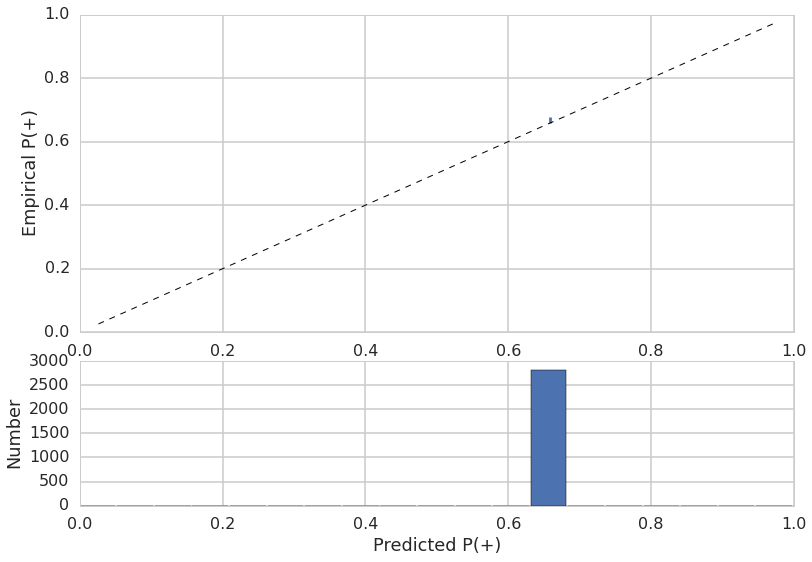

In [147]:
# adapted from Lab 10
vectorizer = CountVectorizer(vocabulary = adjvocab, min_df=best_min_df)
best_X, best_y = make_xy(X, y, vectorizer)
xtrain=best_X[mask]
ytrain=best_y[mask]
xtest=best_X[~mask]
ytest=best_y[~mask]

best_clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)

calibration_plot(clf, xtest, ytest)

#Sentiment Analysis

In [85]:
best_clf.feature_log_prob_.shape

(2, 4840)

In [86]:
logpositives = dict(zip(vectorizer.get_feature_names(), best_clf.feature_log_prob_[1]))
lognegatives = dict(zip(vectorizer.get_feature_names(), best_clf.feature_log_prob_[0]))

In [87]:
def calc_pplus(adjlist, lp, ln, pp, pn):
    pos = 0
    neg = 0
    for adj in adjlist:
        if adj in lp:
            pos += lp[adj]
        if adj in ln:
            neg += ln[adj]
    p = np.exp(pos)*pp
    n = np.exp(neg)*pn
    return pos / (p + n)

In [90]:
reviews=revdf.map(lambda r: r.name).collect()

In [91]:
def choose_topic(ldamodel, bow):
    tee = lda2.get_document_topics(bow)
    if len(tee)==2:
        t1,t2=tee
        if t2[1] >= t1[1]:#get higher probability topic
            topicis=t2[0]
        else:
            topicis=t1[0]
    elif len(tee)==1:#if only one was provided its very high probability. Take it
        teetuple=tee[0]
        topicis=teetuple[0]
    return topicis

In [92]:
counter=0
reviewdict={}
for i, rid in enumerate(reviews):
    rlist=[]
    nlist, alist = parseout[i]
    ln=len(nlist)
    localbow=corpus[counter:counter+ln]
    for bow, adj, noun in zip(localbow, alist, nlist):
        doc=" ".join([id2word[e[0]] for e in bow])
        pplus=calc_pplus(adj, logpositives, lognegatives, priorp, priorn)
        topicis=choose_topic(lda2, bow)
        ldict={"topic": topicis, 'pplus':pplus}
        rlist.append(ldict)
    reviewdict[rid]=rlist
    counter=counter+ln

In [103]:
def extendit(row):
    outlist=[]
    revs=reviewdict[row.name]
    for r in revs:
        r2=r.copy()
        r2['anime_name']=row.anime_name
        r2['name']=row.name
        r2['overall']=row.overall
        r2['user_avg']=row.user_avg
        outlist.append(r2)
    return outlist

In [104]:
%%time
newdfin=revdf.flatMap(lambda r: extendit(r)).cache()

CPU times: user 337 ms, sys: 20 ms, total: 357 ms
Wall time: 363 ms


In [105]:
newdfin.take(2)

[{'anime_name': u'To Aru Majutsu no Index 10th Anniversary PV',
  'name': u'SogiitaGunhaGUTS',
  'overall': 10.0,
  'pplus': -156921.84320766031,
  'topic': 0,
  'user_avg': 10.0},
 {'anime_name': u'Inazuma Eleven',
  'name': u'xxjacobxx3',
  'overall': 9.0,
  'pplus': -5592.6408066012827,
  'topic': 1,
  'user_avg': 7.509302325581395}]

In [106]:
%%time
list_of_dicts=newdfin.collect()

CPU times: user 33.1 ms, sys: 4.15 ms, total: 37.3 ms
Wall time: 123 ms


In [107]:
completedf=pd.DataFrame(list_of_dicts)
completedf.head()

,anime_name,name,overall,pplus,topic,user_avg
0,To Aru Majutsu no Index 10th Anniversary PV,SogiitaGunhaGUTS,10,-156921.843208,0,10.000000
1,Inazuma Eleven,xxjacobxx3,9,-5592.640807,1,7.509302
2,Inazuma Eleven,Lumineux,7,-51707.720099,0,8.045455
3,Inazuma Eleven,Lumineux,7,-111696.440005,1,8.045455
4,Inazuma Eleven,Lumineux,7,-7892.642969,1,8.045455


In [152]:
def get_stats(group):
    d = {} 
    d['min'] = group.pplus.min()
    #d['max'] = group.pplus.max()
    #d['rid'] = pd.Series(group.business_id[:1].values)
    #d['uavg'] = pd.Series(group.user_id[:1].values)
    #d['count'] = pd.Series([len(group.values)])
    #var = np.var(group.pplus.values)
    #if np.isnan(var):
    #    var = 0
    #d['var'] = pd.Series([var])
    #d['mean'] = pd.Series([np.mean(group.pplus)])
    #d['stars'] = pd.Series(group.stars.values[0])
    return pd.DataFrame(d)

In [151]:
%%time
dftouse=completedf.groupby(['anime_name', 'name', 'topic']).apply(get_stats).reset_index()

ValueError: If using all scalar values, you must pass an index